<a href="https://colab.research.google.com/github/ns-0437/Bank-Management-System/blob/master/Lightweight_FineTuning_with_LoRA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lightweight Fine-Tuning Project

In [1]:
# Run this to set up environment, you will need to restart the kernal.
#!pip install matplotlib
#!pip install datasets
#!pip install transformers
#!pip install accelerate -U
#!pip install peft

In [ ]:
tfns = 'zeroshot/twitter-financial-news-sentiment'
mdl = 'gpt2'

In [ ]:
from datasets import load_dataset

# Data has a training and validation set, but no test set.
dataset = load_dataset(tfns)
dataset

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:88: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 9543
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
})

In [ ]:
# Let's split training to include a test set and shuffle the data set in the process.
dataset_splits = dataset['train'].train_test_split(
    test_size=0.2, shuffle=True, seed=42
    )

# add to dataset dictionary
dataset['train'] = dataset_splits['train']
dataset['test'] = dataset_splits['test']

# show dataset
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 7634
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2388
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1909
    })
})

In [ ]:
# Show first entry for train set
dataset['train'][0]

{'text': '6 Easy Credit-Building Tips for First-Time Homebuyers', 'label': 2}

In [ ]:
from transformers import AutoTokenizer

tokenizer = AutoTokenizer.from_pretrained(mdl)
tokenizer.pad_token = tokenizer.eos_token

# Let's use a lambda function to tokenize all the examples
tokenized_dataset = {}
splits = ['train','test','validation']
for split in splits:
    tokenized_dataset[split] = dataset[split].map(
        lambda x: tokenizer(x['text'], padding="max_length", truncation=True), batched=True
    )

# Inspect the available columns in the dataset
tokenized_dataset

Map:   0%|          | 0/1909 [00:00<?, ? examples/s]

{'train': Dataset({
     features: ['text', 'label', 'input_ids', 'attention_mask'],
     num_rows: 7634
 }),
 'test': Dataset({
     features: ['text', 'label', 'input_ids', 'attention_mask'],
     num_rows: 1909
 }),
 'validation': Dataset({
     features: ['text', 'label', 'input_ids', 'attention_mask'],
     num_rows: 2388
 })}

In [ ]:
from transformers import AutoModelForSequenceClassification

model = AutoModelForSequenceClassification.from_pretrained(
    mdl,
    num_labels=3,
    id2label={0: 'Bearish', 1: 'Bullish', 2: 'Neutral'},
    label2id={'Bearish': 0, 'Bullish': 1, 'Neutral': 2},
)
model.config.pad_token_id = tokenizer.eos_token_id


# Freeze the model base parameters
for param in model.base_model.parameters():
    param.requires_grad = False

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
print(model)

GPT2ForSequenceClassification(
  (transformer): GPT2Model(
    (wte): Embedding(50257, 768)
    (wpe): Embedding(1024, 768)
    (drop): Dropout(p=0.1, inplace=False)
    (h): ModuleList(
      (0-11): 12 x GPT2Block(
        (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (attn): GPT2Attention(
          (c_attn): Conv1D()
          (c_proj): Conv1D()
          (attn_dropout): Dropout(p=0.1, inplace=False)
          (resid_dropout): Dropout(p=0.1, inplace=False)
        )
        (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (mlp): GPT2MLP(
          (c_fc): Conv1D()
          (c_proj): Conv1D()
          (act): NewGELUActivation()
          (dropout): Dropout(p=0.1, inplace=False)
        )
      )
    )
    (ln_f): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
  )
  (score): Linear(in_features=768, out_features=3, bias=False)
)


In [ ]:
import numpy as np
from transformers import DataCollatorWithPadding, Trainer, TrainingArguments

# evaluation metrics
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    predictions = np.argmax(predictions, axis=1)
    return {"accuracy": (predictions == labels).mean()}

# plot function
import matplotlib.pyplot as plt
def plot_results(df):
    accuracy = (df['predictions'] == df['actual']).mean()
    plt.hist(x=df, bins='auto', label=['predicted', 'actual'])
    plt.legend()
    plt.title('Accuracy: %0.0f%%' % (100*accuracy))

In [ ]:
# The HuggingFace Trainer class handles the training and eval loop for PyTorch for us.
# Read more about it here https://huggingface.co/docs/transformers/main_classes/trainer
trainer = Trainer(
    model=model,
    args=TrainingArguments(
        output_dir="./data/tnst",
        # Set the learning rate
        learning_rate = 2e-5,
        # Set the per device train batch size and eval batch size
        per_device_train_batch_size = 16,
        per_device_eval_batch_size = 16,
        # Evaluate and save the model after each epoch
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=2,
        weight_decay=0.01,
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["validation"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()

You're using a GPT2TokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Epoch,Training Loss,Validation Loss,Accuracy
1,No log,0.869559,0.651591
2,1.055000,0.857673,0.654941


TrainOutput(global_step=956, training_loss=1.0119212641376831, metrics={'train_runtime': 598.0568, 'train_samples_per_second': 25.529, 'train_steps_per_second': 1.599, 'total_flos': 7979029619539968.0, 'train_loss': 1.0119212641376831, 'epoch': 2.0})

Now run on the validation set:

In [ ]:
trainer.evaluate()

{'eval_loss': 0.8576732873916626,
 'eval_accuracy': 0.6549413735343383,
 'eval_runtime': 64.8257,
 'eval_samples_per_second': 36.837,
 'eval_steps_per_second': 2.314,
 'epoch': 2.0}

Save the model for reuse

In [ ]:
model.save_pretrained('gpt2-sentiment')

In [ ]:
predicted = trainer.predict(tokenized_dataset['test'])
import pandas as pd
df = pd.DataFrame(
    {
        "predictions": predicted.predictions.argmax(axis=1),
        "actual": predicted.label_ids,
    }
)
df

,predictions,actual
0,2,2
1,2,1
2,2,1
3,2,2
4,2,2
...,...,...
1904,2,1
1905,2,2
1906,2,2
1907,2,2


Plot the results.

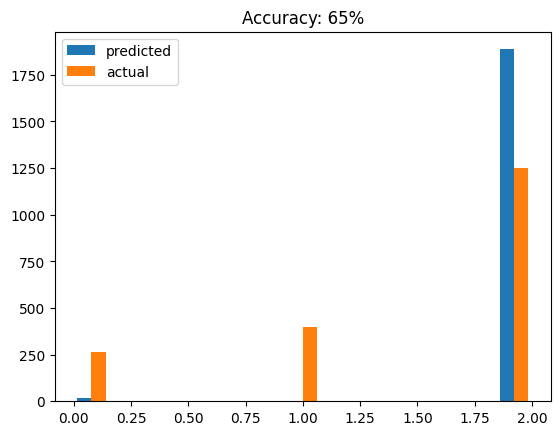

In [ ]:
plot_results(df)

In [ ]:
from peft import get_peft_config, get_peft_model, LoraConfig, TaskType
# lora configuration
config = LoraConfig(
    task_type=TaskType.SEQ_CLS,
    inference_mode=False,
    r=8,
    lora_alpha=32,
    lora_dropout=0.1,
    bias = 'none',
    target_modules=['c_attn', 'c_proj']
)

# load in the saved gpt2-sentiment model
from transformers import AutoModelForSequenceClassification
model = AutoModelForSequenceClassification.from_pretrained('gpt2-sentiment')

# create the lora model
lora_model = get_peft_model(model, config)
lora_model.print_trainable_parameters()

trainable params: 813,312 || all params: 125,255,424 || trainable%: 0.6493227790279166


/usr/local/lib/python3.10/dist-packages/peft/tuners/lora/layer.py:711: UserWarning: fan_in_fan_out is set to False but the target module is `Conv1D`. Setting fan_in_fan_out to True.
  warnings.warn(


In [ ]:
lora_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): GPT2ForSequenceClassification(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D()
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict(

Lets train the LoRA model


In [ ]:
trainer = Trainer(
    model=lora_model,
    args=TrainingArguments(
        output_dir="./data/tnst-lora",
        # Set the learning rate
        learning_rate = 2e-5,
        # Set the per device train batch size and eval batch size
        per_device_train_batch_size = 4,
        per_device_eval_batch_size = 4,
        # Evaluate and save the model after each epoch
        evaluation_strategy="epoch",
        save_strategy="epoch",
        num_train_epochs=2,
        weight_decay=0.01,
        load_best_model_at_end=True,
    ),
    train_dataset=tokenized_dataset["train"],
    eval_dataset=tokenized_dataset["test"],
    tokenizer=tokenizer,
    data_collator=DataCollatorWithPadding(tokenizer=tokenizer),
    compute_metrics=compute_metrics,
)

trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy
1,0.784900,0.635091,0.740178
2,0.690400,0.588440,0.761131


TrainOutput(global_step=3818, training_loss=0.7553206933862318, metrics={'train_runtime': 1298.9477, 'train_samples_per_second': 11.754, 'train_steps_per_second': 2.939, 'total_flos': 8055323646492672.0, 'train_loss': 0.7553206933862318, 'epoch': 2.0})

In [ ]:
trainer.evaluate()

{'eval_loss': 0.5884400606155396,
 'eval_accuracy': 0.7611314824515453,
 'eval_runtime': 60.4915,
 'eval_samples_per_second': 31.558,
 'eval_steps_per_second': 7.902,
 'epoch': 2.0}

Saving the model to reuse it again

In [ ]:
lora_model.save_pretrained("gpt2-lora")

In [ ]:
predicted = trainer.predict(tokenized_dataset['test'])
actual = np.array(tokenized_dataset['test']['label'])
x = np.stack((predicted.label_ids, actual))
import pandas as pd
df = pd.DataFrame(
    {
        "predictions": predicted.predictions.argmax(axis=1),
        "actual": predicted.label_ids,
    }
)
df

,predictions,actual
0,1,2
1,2,1
2,2,1
3,2,2
4,2,2
...,...,...
1904,1,1
1905,2,2
1906,2,2
1907,2,2


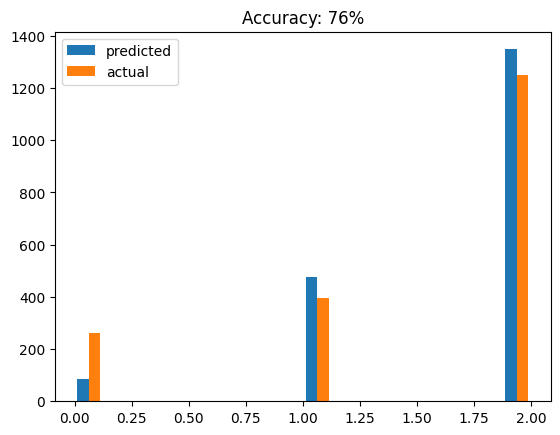

In [ ]:
plot_results(df)

In [ ]:
ind = 6
df.iloc[ind], tokenized_dataset['test'][ind]['text']

(predictions    1
 actual         1
 Name: 6, dtype: int64,
 'Fluidigm EPS beats by $0.06, beats on revenue')

In [ ]:
ind = df['predictions']==2
df[ind]

,predictions,actual
1,2,1
2,2,1
3,2,2
4,2,2
5,2,2
...,...,...
1901,2,2
1905,2,2
1906,2,2
1907,2,2


We can see a dramatic improvement in the prediction accuracy.

In [ ]:
# load in the model
from peft import AutoPeftModelForSequenceClassification
inference_model = AutoPeftModelForSequenceClassification.from_pretrained('gpt2-lora')
inference_model

PeftModelForSequenceClassification(
  (base_model): LoraModel(
    (model): GPT2ForSequenceClassification(
      (transformer): GPT2Model(
        (wte): Embedding(50257, 768)
        (wpe): Embedding(1024, 768)
        (drop): Dropout(p=0.1, inplace=False)
        (h): ModuleList(
          (0-11): 12 x GPT2Block(
            (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
            (attn): GPT2Attention(
              (c_attn): lora.Linear(
                (base_layer): Conv1D()
                (lora_dropout): ModuleDict(
                  (default): Dropout(p=0.1, inplace=False)
                )
                (lora_A): ModuleDict(
                  (default): Linear(in_features=768, out_features=8, bias=False)
                )
                (lora_B): ModuleDict(
                  (default): Linear(in_features=8, out_features=2304, bias=False)
                )
                (lora_embedding_A): ParameterDict()
                (lora_embedding_B): ParameterDict(

In [ ]:
tokenizer = AutoTokenizer.from_pretrained("gpt2")

# sentiment function
def get_sentiment(tweet):
    inputs = tokenizer(tweet, return_tensors="pt")
    logits = inference_model(**inputs).logits
    predicted_class_id = logits.argmax().item()
    print("Sentiment: ")
    return inference_model.config.id2label[predicted_class_id]

# try it out on a bullish statement
get_sentiment('The Fed just slashed interest rates by a quarter of a percent')

Sentiment: 


'Bearish'

In [ ]:
# a bearish sentiment
get_sentiment('Germanany''s industrial economy is dragging down the eurozone')

Sentiment: 


'Bearish'

In [ ]:
# a neutral sentiment
get_sentiment('War in Ukraine is expected to last for years')

Sentiment: 


'Neutral'